In [1]:
#!pip install comet_ml
!pip install wandb
#from comet_ml import Experiment
#from comet_ml.integration.pytorch import log_model
#!pip uninstall comet_ml -y
#!pip uninstall wandb -y
!pip install tqdm scikit-learn
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import wandb
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import json

#wandb.require("core")
wandb.login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
class LSTM(nn.Module):
  """
  LSTM model for stock market time series prediction
  """
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_rate):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout= dropout_rate)
    self.fc   = nn.Linear(hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.dropout(out)
    # Take the output from the last time step only
    out = out[:, -1, :]
    out = self.fc(out)
    return out

In [3]:
data = pd.read_csv("JSE_clean_truncated.csv")
data.shape # 3146 daily closing prices for 30 stocks
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized = pd.DataFrame(data_normalized, columns=data.columns)
data_normalized.head()


,ASPEN,CAPITEC,IMPLATS,GROWPNT,NORTHAM,ANGGOLD,BATS,EXXARO,WOOLIES,NASPERS-N-,...,INVPLC,DISCOVERY,AMPLATS,ANGLO,FIRSTRAND,NEDBANK,SASOL,SPAR,VODACOM,MTN_GROUP
0,-1.391421,-1.187224,0.713365,-1.714268,-0.561388,0.681714,-1.643102,-1.536572,-1.902418,-1.302682,...,-1.317077,-1.587228,-0.294808,-0.851026,-1.704961,-1.923158,-0.642344,-2.052116,-1.874596,-0.461779
1,-1.401461,-1.188341,0.789006,-1.634837,-0.551483,0.661609,-1.667095,-1.495109,-1.889293,-1.301169,...,-1.240808,-1.577129,-0.248859,-0.740668,-1.690249,-1.820279,-0.600067,-2.041210,-1.938359,-0.358794
2,-1.411888,-1.188341,0.835903,-1.634837,-0.592577,0.753090,-1.689613,-1.479803,-1.884918,-1.309326,...,-1.287159,-1.588350,-0.273185,-0.682041,-1.714965,-1.852370,-0.593989,-2.052116,-1.938359,-0.293533
3,-1.416715,-1.187783,0.702775,-1.634837,-0.563495,0.721926,-1.668029,-1.564399,-1.903293,-1.303675,...,-1.354579,-1.590369,-0.235344,-0.735742,-1.700253,-1.890123,-0.686383,-2.037720,-1.976617,-0.380475
4,-1.426273,-1.187783,0.890062,-1.634837,-0.562442,0.809486,-1.675502,-1.453646,-1.902418,-1.302250,...,-1.320869,-1.580944,-0.229668,-0.691402,-1.724380,-1.865206,-0.597424,-2.019399,-1.939953,-0.358794


In [4]:
def create_sequences(data, window_size, horizon, target_stock=None):
  """
  Creates input-output pairs for LSTM

  Parameters:
    - data : Normalized stock prices
    - window_size: Number of past days to consider
    - horizon: Number of days ahead to predict
  Returns
    - x: Input sequences
    - y: Target sequences
  """
  x, y = [], []
  if target_stock is None:
    total_samples = (len(data) - window_size - horizon + 1)
    for t in range(0, total_samples, window_size):
      x_t = data.iloc[t:t+window_size].values
      y_t = data.iloc[t + window_size + horizon  - 1].values
      x.append(x_t)
      y.append(y_t)
    x = np.array(x)
    y = np.array(y)
  else:
    total_samples = (len(data) - window_size - horizon + 1)
    for t in range(0, total_samples, window_size):
      x_t = data.iloc[t:t+window_size][target_stock].values
      x_t = x_t.reshape(-1, 1)
      y_t = data.iloc[t + window_size + horizon  - 1][target_stock]
      x.append(x_t)
      y.append(y_t)
    x = np.array(x)
    y = np.array(y).reshape(-1, 1)
  return x, y

In [5]:
def train_val_test_split(x, y, train_ratio=0.7, val_ratio=0.15):
  """
  Splits the data into train, validation, and test sets
  """
  total_samples = len(x)
  train_end     = int(total_samples * train_ratio)
  val_end       = train_end + int(total_samples * val_ratio)
  X_train       = x[:train_end]
  y_train       = y[:train_end]
  X_val         = x[train_end:val_end]
  y_val         = y[train_end:val_end]
  X_test        = x[val_end:]
  y_test        = y[val_end:]

  return X_train, y_train, X_val, y_val, X_test, y_test

def create_datasets(window_sizes, horizons, stocks=None):
  """
  Creates datasets for different window sizes and horizons
  """
  datasets = {}
  if stocks is None:
    for window_size in window_sizes:
      for horizon in horizons:
        x, y = create_sequences(data_normalized, window_size, horizon)
        datasets[(window_size, horizon)] = {'x': x, 'y': y}
        #print(f"Dataset for window size {window_size} and horizon {horizon} created.")
  else:
      for window_size in window_sizes:
        for horizon in horizons:
          for stock in stocks:
            x, y = create_sequences(data_normalized, window_size, horizon, stock)
            datasets[(window_size, horizon, stock)] = {'x': x, 'y': y}
            print(f"Dataset for stock {stock}, window size {window_size} and horizon {horizon} created.")


  for key in datasets.keys():
      X = datasets[key]['x']
      y = datasets[key]['y']
      X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)
      datasets[key]['train'] = {'x': X_train, 'y': y_train}
      datasets[key]['val'] = {'x': X_val, 'y': y_val}
      datasets[key]['test'] = {'x': X_test, 'y': y_test}
      del datasets[key]['x']
      del datasets[key]['y']
      print(f" - Split into Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
  return datasets

In [6]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        """
        Initializes the dataset with inputs and targets.

        Parameters:
        - X (np.ndarray): Input sequences.
        - y (np.ndarray): Targets.
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def create_dataloaders(datasets, batch_size=32, window_size=None, horizon=None, stock=None):
  if(window_size is not None and horizon is not None):

    key = (window_size, horizon)
    if stock is not None:
      key = (window_size, horizon, stock)

    dataloaders = {}
    dataloaders[key] = {}
    for split in ['train', 'val', 'test']:
      X = datasets[key][split]['x']
      y = datasets[key][split]['y']
      dataset = StockDataset(X, y)
      dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
      dataloaders[key][split] = dataloader
    return dataloaders

  dataloaders = {}
  for key in datasets.keys():
      dataloaders[key] = {}
      for split in ['train', 'val', 'test']:
          X = datasets[key][split]['x']
          y = datasets[key][split]['y']
          dataset = StockDataset(X, y)
          dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
          dataloaders[key][split] = dataloader
  return dataloaders



In [7]:
# Loss Metrics

def mean_absolute_error(y_pred, y_true):
    return torch.mean(torch.abs(y_true - y_pred)).item()

def mean_absolute_percentage_error(y_pred, y_true):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)).item() * 100

def root_mean_square_error(y_pred, y_true):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()

In [8]:
def hyperparameter_tuning(datasets, window_size, horizon, sequence_length, param_grid, num_epochs=100, stock=None):

    # Set device for computation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    best_hyperparameters = None
    best_val_loss = float('inf')  # Initialize to infinity

    # Create a parameter grid from the dictionary
    grid = ParameterGrid(param_grid)
    total_train_time = 0  # Initialize total training time

    # Use tqdm to create a progress bar for hyperparameter combinations
    for params in tqdm(grid, desc=f"Hyperparameter Tuning for Input Window {window_size}"):
        hidden_dim    = params['hidden_dim']
        num_layer     = params['num_layers']
        learning_rate = params['learning_rate']
        batch_size    = params['batch_size']
        dropout_rate  = params['dropout_rate']
        #output_dim    = params['output_dim']

        print(f"Training with parameters: {params}")
        wandb.init(
          # set the wandb project where this run will be logged
          project="Stock Prediction using LSTM",
          name=f"window_{window_size}_horizon_{horizon}_stock_{stock}_hidden_{hidden_dim}_layers_{num_layer}_lr_{learning_rate}_batch_{batch_size}_dropout_{dropout_rate}",
          config=params,
          job_type="model-training"
        )

        dataloaders    = {}
        selected_key   = (window_size, horizon)
        if stock is not None:
          dataloaders    = create_dataloaders(datasets,batch_size, window_size, horizon, stock)
          selected_key   = (window_size, horizon, stock)
        else:
          dataloaders    = create_dataloaders(datasets,batch_size, window_size, horizon)
        train_loader   = dataloaders[selected_key]['train']
        val_loader     = dataloaders[selected_key]['val']

        # Initialize model
        model = LSTM(
            input_dim=sequence_length,
            hidden_dim=hidden_dim,
            num_layers=num_layer,
            output_dim=horizon,
            dropout_rate=dropout_rate
        ).to(device)

        # Set optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.L1Loss()  # Default criterion (MAE)


        for epoch in range(num_epochs):
            start_time = time.time()  # Start time for the epoch
            model.train()
            train_loss = 0

            # Additional metrics
            train_mape = 0
            train_rmse = 0
            train_batches = 0

            # Training phase
            for batch_idx, (x, y) in enumerate(train_loader):
                x_batch, y_batch = x.to(device), y.to(device)
                optimizer.zero_grad()
                output = model(x_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                # Calculate additional metrics
                train_mape += mean_absolute_percentage_error(output, y_batch)
                train_rmse += root_mean_square_error(output, y_batch)
                train_batches += 1

            # Average training metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_train_mape = train_mape / train_batches
            avg_train_rmse = train_rmse / train_batches

            # Validation phase
            model.eval()
            valid_loss = 0
            valid_mape = 0
            valid_rmse = 0
            valid_batches = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x_batch, y_batch = x.to(device), y.to(device)
                    output = model(x_batch)
                    loss = criterion(output, y_batch)
                    valid_loss += loss.item()
                    # Calculate additional metrics
                    valid_mape += mean_absolute_percentage_error(output, y_batch)
                    valid_rmse += root_mean_square_error(output, y_batch)
                    valid_batches += 1

            # Average validation metrics
            avg_valid_loss = valid_loss / len(val_loader)
            avg_valid_mape = valid_mape / valid_batches
            avg_valid_rmse = valid_rmse / valid_batches

            # End of epoch log
            epoch_duration = time.time() - start_time
            total_train_time += epoch_duration

            print("--------------------------------------------------------------------------------")
            print(f"end of epoch {epoch + 1:<3} | time: {epoch_duration:>5.2f}s | "
                  f"train MAE {avg_train_loss:>6.4f} | valid MAE {avg_valid_loss:>6.4f}")
            print(f"train MAPE: {avg_train_mape:>6.4f} | valid MAPE: {avg_valid_mape:>6.4f}")
            print(f"train RMSE: {avg_train_rmse:>6.4f} | valid RMSE: {avg_valid_rmse:>6.4f}")
            print("--------------------------------------------------------------------------------")

            # Log all metrics to wandb
            wandb.log({
                "train_mae": avg_train_loss,
                "val_mae": avg_valid_loss,
                "train_mape": avg_train_mape,
                "val_mape": avg_valid_mape,
                "train_rmse": avg_train_rmse,
                "val_rmse": avg_valid_rmse,
                "epoch": epoch + 1,
                "epoch_time": epoch_duration,
                "total_train_time": total_train_time + epoch_duration
            })


        # Update best hyperparameters based on validation loss
        if avg_valid_loss < best_val_loss:
            best_val_loss = avg_valid_loss
            best_hyperparameters = params.copy()
            best_hyperparameters['train_mae'] = avg_train_loss
            best_hyperparameters['train_mape'] = avg_train_mape
            best_hyperparameters['train_rmse'] = avg_train_rmse
            best_hyperparameters['val_mae'] = avg_valid_loss
            best_hyperparameters['val_mape'] = avg_valid_mape
            best_hyperparameters['val_rmse'] = avg_valid_rmse
            best_hyperparameters['total_train_time'] = total_train_time


    return best_hyperparameters, best_val_loss


# Training

In [9]:
stocks             = data.columns.tolist()  # List of all 30 stock names
window_sizes       = [30, 60, 120]
horizons           = [1, 2, 5, 10, 30]
datasets           = create_datasets(window_sizes=window_sizes, horizons=horizons, stocks=stocks[0:10])

sequence_length    = 1
output_dim         = [1, 2, 5, 10, 30]
num_epochs         = 50
best_hyperparameters_dict = {}

# Hyperparameters
hidden_dim    = [32, 64]
num_layers    = [2, 8]
dropout_rate  = [0.1, 0.2]
learning_rate = [1e-3]
batch_size    = [32, 64]

param_grid = {
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'dropout_rate': dropout_rate,
    #'output_dim': output_dim
}
stock = stocks[0]

def train(datsets, window_sizes, sequence_length, param_grid, num_epocs, stock=None):
  for window_size in window_sizes:
    for horizon in horizons:
      best_hyperparameters, best_val_loss = hyperparameter_tuning(
          datasets,
          window_size,
          horizon,
          sequence_length,
          param_grid,
          num_epochs,
          stock
          )
      best_hyperparameters_dict[(window_size,horizon)] = {
          "best_hyperparameters": best_hyperparameters,
          "best_val_loss": best_val_loss
      }

      print(f"Best Hyperparameters for window={window_size} and horizon={horizon}: {best_hyperparameters}")
      print(f"Best Validation Loss: {best_val_loss:.4f}")


  print("\nSummary of Best Hyperparameters for Each (Window, Horizon):")
  for key, value in best_hyperparameters_dict.items():
      print(f"Window={key[0]}, Horizon={key[1]} -> {value['best_hyperparameters']} | Validation Loss: {value['best_val_loss']:.4f}")
  with open('best_hyperparameters.json', 'w') as f:
      # Convert tuple keys to strings
      json.dump({str(k): v for k, v in best_hyperparameters_dict.items()}, f, indent=4, default=str)


#train(datasets, window_sizes, sequence_length, param_grid, num_epochs, stock)


Dataset for stock ASPEN, window size 30 and horizon 1 created.
Dataset for stock CAPITEC, window size 30 and horizon 1 created.
Dataset for stock IMPLATS, window size 30 and horizon 1 created.
Dataset for stock GROWPNT, window size 30 and horizon 1 created.
Dataset for stock NORTHAM, window size 30 and horizon 1 created.
Dataset for stock ANGGOLD, window size 30 and horizon 1 created.
Dataset for stock BATS, window size 30 and horizon 1 created.
Dataset for stock EXXARO, window size 30 and horizon 1 created.
Dataset for stock WOOLIES, window size 30 and horizon 1 created.
Dataset for stock NASPERS-N-, window size 30 and horizon 1 created.
Dataset for stock ASPEN, window size 30 and horizon 2 created.
Dataset for stock CAPITEC, window size 30 and horizon 2 created.
Dataset for stock IMPLATS, window size 30 and horizon 2 created.
Dataset for stock GROWPNT, window size 30 and horizon 2 created.
Dataset for stock NORTHAM, window size 30 and horizon 2 created.
Dataset for stock ANGGOLD, win

# **Evaluating on Test Data**

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a function to evaluate the LSTM model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss, total_mape, total_rmse = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x_batch, y_batch = x.to(device), y.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Calculate metrics
            mape = mean_absolute_percentage_error(outputs, y_batch)
            rmse = root_mean_square_error(outputs, y_batch)

            total_loss += loss.item()
            total_mape += mape
            total_rmse += rmse

    return total_loss / len(test_loader), total_mape / len(test_loader), total_rmse / len(test_loader)

# Function to initialize the model with hyperparameters
def run_model(sequence_length, params, test_loader):
    model = LSTM(
        input_dim=sequence_length,
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        output_dim=params['output_dim'],
        dropout_rate=params['dropout_rate']
    ).to(device)

    # Loss function
    criterion = nn.L1Loss()

    # Evaluate the model
    val_mae, val_mape, val_rmse = evaluate_model(model, test_loader, criterion)
    return val_mae, val_mape, val_rmse


# Best hyperparameters for each model configuration
models = {
    (30, 1): {
            "batch_size": 32,
            "dropout_rate": 0.2,
            "hidden_dim": 64,
            "learning_rate": 0.001,
            "num_layers": 2,
            "output_dim": 1,
    },
    (60, 1): {
            "batch_size": 32,
            "dropout_rate": 0.2,
            "hidden_dim": 64,
            "learning_rate": 0.001,
            "num_layers": 2,
            "output_dim": 1,
    },
    (120, 2): {
            "batch_size": 32,
            "dropout_rate": 0.2,
            "hidden_dim": 64,
            "learning_rate": 0.001,
            "num_layers": 2,
            "output_dim": 2,
    }
}

test_results = {}
stock = stocks[0]
sequence_length = 1


for key in models.keys():
  window_size, horizon = key
  batch_size           = models[key]['batch_size']
  dataloaders          = create_dataloaders(datasets,batch_size, window_size, horizon, stock)
  selected_key         = (window_size, horizon, stock)
  test_loader          = dataloaders[selected_key]['test']
  model_results = {"mae": [], "mape": [], "rmse": []}
  wandb.init(
      # set the wandb project where this run will be logged
      project="Stock Prediction using LSTM",
      name=f"Model_{key}",
      config=models[key],
      job_type="model-training"
    )
  for run in range(5):
    test_mae, test_mape, test_rmse = run_model(sequence_length, models[key], test_loader)
    model_results["mae"].append(test_mae)
    model_results["mape"].append(test_mape)
    model_results["rmse"].append(test_rmse)
    wandb.log({
            "test_mae": test_mae,
            "test_mape": test_mape,
            "test_rmse": test_rmse,
        })
    print(f"Run {run + 1}: MAE={test_mae:.4f}, MAPE={test_mape:.4f}, RMSE={test_rmse:.4f}")
  test_results[key] = model_results
wandb.finish()
print("Test results for each model configuration:", test_results)


wandb: Currently logged in as: rbukurucapital (uctresearch). Use `wandb login --relogin` to force relogin


Run 1: MAE=0.7136, MAPE=103.3885, RMSE=0.7496
Run 2: MAE=0.7682, MAPE=112.3009, RMSE=0.8020
Run 3: MAE=0.6255, MAPE=88.8294, RMSE=0.6672
Run 4: MAE=0.5679, MAPE=79.4963, RMSE=0.6130
Run 5: MAE=0.5878, MAPE=82.8024, RMSE=0.6311


test_mae,▆█▃▁▂
test_mape,▆█▃▁▂
test_rmse,▆█▃▁▂
test_mae,0.58781
test_mape,82.80238
test_rmse,0.63107


Run 1: MAE=0.6047, MAPE=85.0072, RMSE=0.6462
Run 2: MAE=0.7447, MAPE=108.1105, RMSE=0.7793
Run 3: MAE=0.6228, MAPE=87.9354, RMSE=0.6635
Run 4: MAE=0.7888, MAPE=115.5522, RMSE=0.8210
Run 5: MAE=0.5650, MAPE=78.4047, RMSE=0.6094


test_mae,▂▇▃█▁
test_mape,▂▇▃█▁
test_rmse,▂▇▃█▁
test_mae,0.56498
test_mape,78.40466
test_rmse,0.60936


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Run 1: MAE=0.6194, MAPE=99.6162, RMSE=0.6514
Run 2: MAE=0.5933, MAPE=94.8612, RMSE=0.6266
Run 3: MAE=0.6524, MAPE=105.7528, RMSE=0.6935
Run 4: MAE=0.6324, MAPE=102.1093, RMSE=0.6648
Run 5: MAE=0.6321, MAPE=102.0106, RMSE=0.6657


test_mae,▄▁█▆▆
test_mape,▄▁█▆▆
test_rmse,▄▁█▅▅
test_mae,0.63214
test_mape,102.01057
test_rmse,0.66574


Test results for each model configuration: {(30, 1): {'mae': [0.713565468788147, 0.7682411074638367, 0.625519335269928, 0.5679487586021423, 0.5878090262413025], 'mape': [103.38854789733887, 112.30088472366333, 88.82936239242554, 79.49625849723816, 82.80237913131714], 'rmse': [0.7495668530464172, 0.8019598722457886, 0.6671847701072693, 0.6129745841026306, 0.6310682892799377]}, (60, 1): {'mae': [0.6046555042266846, 0.7447323203086853, 0.6227601170539856, 0.7888432145118713, 0.5649769306182861], 'mape': [85.00723242759705, 108.11053514480591, 87.93542981147766, 115.55224657058716, 78.40465903282166], 'rmse': [0.6461635231971741, 0.7792811393737793, 0.6635094285011292, 0.8209747672080994, 0.609356701374054]}, (120, 2): {'mae': [0.6193541884422302, 0.5932855010032654, 0.6524085402488708, 0.6324240565299988, 0.6321423649787903], 'mape': [99.61622357368469, 94.86123323440552, 105.75277805328369, 102.10925340652466, 102.01057195663452], 'rmse': [0.6513835191726685, 0.6266056895256042, 0.693524

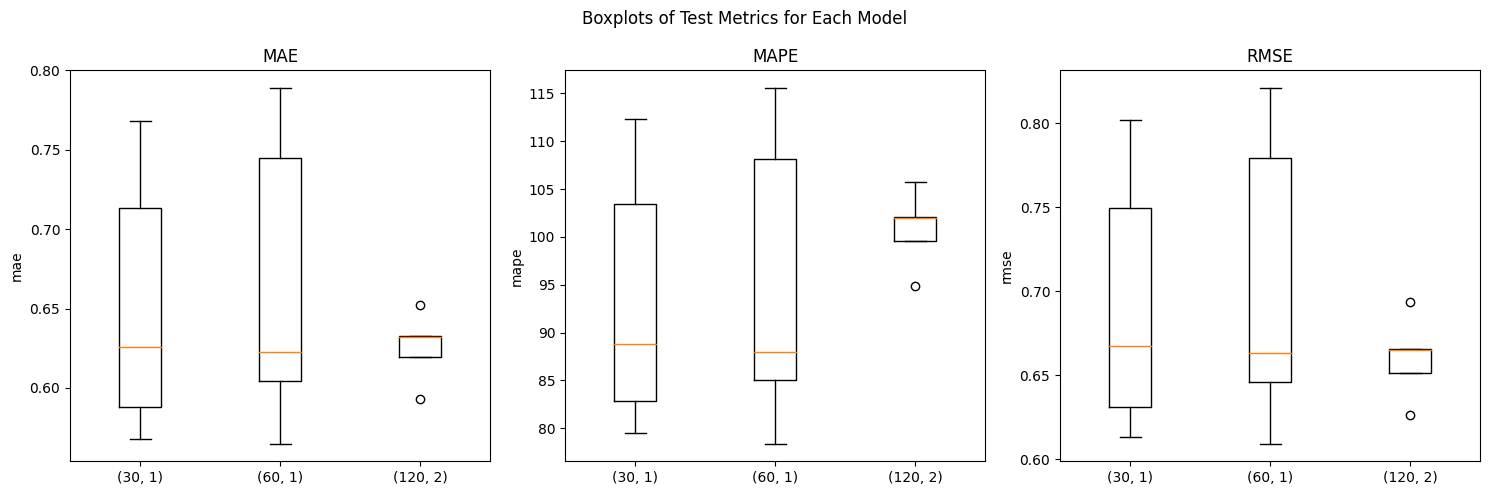

In [11]:
import matplotlib.pyplot as plt

# Re-import necessary libraries due to code reset
import numpy as np

# Test results for each model


# Extracting metrics for each model
metrics = ["mae", "mape", "rmse"]
models = [(30, 1), (60, 1), (120, 2)]

# Creating boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, metric in enumerate(metrics):
    data = [test_results[model][metric] for model in models]
    axes[idx].boxplot(data)
    axes[idx].set_title(metric.upper())
    axes[idx].set_xticklabels(models)
    axes[idx].set_ylabel(metric)

plt.suptitle("Boxplots of Test Metrics for Each Model")
plt.tight_layout()
plt.show()
